In [30]:
import tensorflow as tf
import tflite_model_maker as mm
from tflite_model_maker import audio_classifier
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import glob
import random

from IPython.display import Audio, Image
from scipy.io import wavfile

print(f"TensorFlow Version: {tf.__version__}")
print(f"Model Maker Version: {mm.__version__}")

TensorFlow Version: 2.9.1
Model Maker Version: 0.3.4


In [31]:
# @title [Run this] Util functions and data structures.

data_dir = './dataset/small_birds_dataset'

bird_code_to_name = {
  'wbwwre1': 'White-breasted Wood-Wren',
  'houspa': 'House Sparrow',
  'redcro': 'Red Crossbill',  
  'chcant2': 'Chestnut-crowned Antpitta',
  'azaspi1': "Azara's Spinetail",   
}

birds_images = {
  'wbwwre1': 'https://upload.wikimedia.org/wikipedia/commons/thumb/2/22/Henicorhina_leucosticta_%28Cucarachero_pechiblanco%29_-_Juvenil_%2814037225664%29.jpg/640px-Henicorhina_leucosticta_%28Cucarachero_pechiblanco%29_-_Juvenil_%2814037225664%29.jpg', #   Alejandro Bayer Tamayo from Armenia, Colombia 
  'houspa': 'https://upload.wikimedia.org/wikipedia/commons/thumb/5/52/House_Sparrow%2C_England_-_May_09.jpg/571px-House_Sparrow%2C_England_-_May_09.jpg', #    Diliff
  'redcro': 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/49/Red_Crossbills_%28Male%29.jpg/640px-Red_Crossbills_%28Male%29.jpg', #  Elaine R. Wilson, www.naturespicsonline.com
  'chcant2': 'https://upload.wikimedia.org/wikipedia/commons/thumb/6/67/Chestnut-crowned_antpitta_%2846933264335%29.jpg/640px-Chestnut-crowned_antpitta_%2846933264335%29.jpg', #   Mike's Birds from Riverside, CA, US
  'azaspi1': 'https://upload.wikimedia.org/wikipedia/commons/thumb/b/b2/Synallaxis_azarae_76608368.jpg/640px-Synallaxis_azarae_76608368.jpg', # https://www.inaturalist.org/photos/76608368
}

test_files = os.path.abspath(os.path.join(data_dir, 'test/*/*.wav'))

def get_random_audio_file():
  test_list = glob.glob(test_files)
  random_audio_path = random.choice(test_list)
  return random_audio_path


def show_bird_data(audio_path):
  sample_rate, audio_data = wavfile.read(audio_path, 'rb')

  bird_code =audio_path.split('\\')[-2]
  print(f'Bird name: {bird_code_to_name[bird_code]}')
  print(f'Bird code: {bird_code}')
  display(Image(birds_images[bird_code]))

  plttitle = f'{bird_code_to_name[bird_code]} ({bird_code})'
  plt.title(plttitle)
  plt.plot(audio_data)
  display(Audio(audio_data, rate=sample_rate))

print('functions and data structures created')

functions and data structures created


Bird name: Red Crossbill
Bird code: redcro


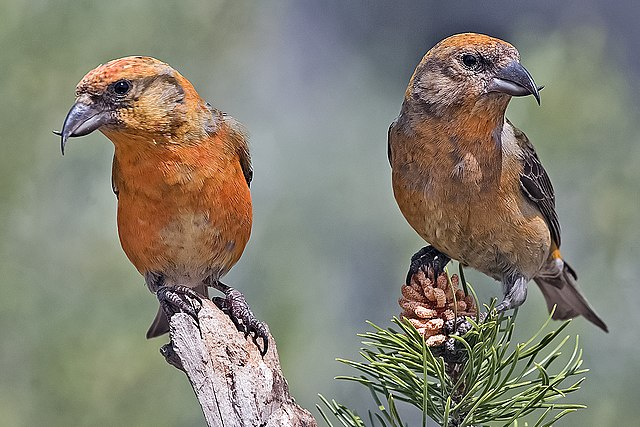

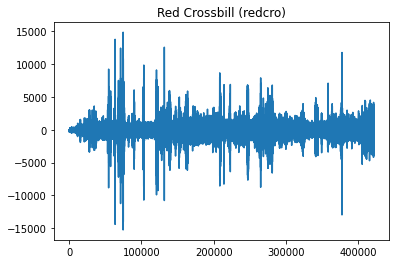

In [33]:
random_audio = get_random_audio_file()
show_bird_data(random_audio)

In [34]:
#classifier name is yamenetspec
spec = audio_classifier.YamNetSpec(
    keep_yamnet_and_custom_heads=True,
    frame_step=3 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH,
    frame_length=6 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH)

INFO:tensorflow:Checkpoints are stored in C:\Users\Dell\AppData\Local\Temp\tmp_zrrzr9s


INFO:tensorflow:Checkpoints are stored in C:\Users\Dell\AppData\Local\Temp\tmp_zrrzr9s


In [35]:
train_data = audio_classifier.DataLoader.from_folder(
    spec, os.path.join(data_dir, 'train'), cache=True)
train_data, validation_data = train_data.split(0.8)
test_data = audio_classifier.DataLoader.from_folder(
    spec, os.path.join(data_dir, 'test'), cache=True)

In [15]:
batch_size = 128
epochs = 100

print('Training the model')
model = audio_classifier.create(
    train_data,
    spec,
    validation_data,
    batch_size=batch_size,
    epochs=epochs)

Training the model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 classification_head (Dense)  (None, 5)                5125      
                                                                 
Total params: 5,125
Trainable params: 5,125
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
22/22 [==============================] - 79s 3s/step - loss: 1.5337 - acc: 0.2910 - val_loss: 1.2010 - val_acc: 0.6797
Epoch 2/100
22/22 [==============================] - 0s 13ms/step - loss: 1.2819 - acc: 0.5079 - val_loss: 1.0358 - val_acc: 0.6864
Epoch 3/100
22/22 [==============================] - 0s 12ms/step - loss: 1.1588 - acc: 0.5883 - val_loss: 0.9641 - val_acc: 0.7079
Epoch 4/100
22/22 [==============================] - 0s 12ms/step - loss: 1.0508 - acc: 0.6501 - val_loss: 0.9062 - val_acc: 0.7241
Epoch 5/100
22/22 [=================

In [16]:
print('Evaluating the model')
model.evaluate(test_data)

Evaluating the model
28/28 [==============================] - 20s 665ms/step - loss: 0.5965 - acc: 0.7887


[0.5965270400047302, 0.788748562335968]

1/1 [==============================] - 0s 39ms/step


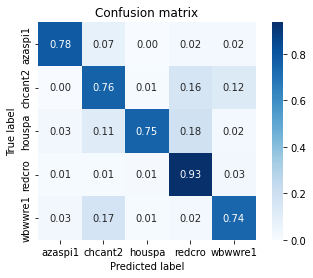

In [17]:
def show_confusion_matrix(confusion, test_labels):
  """Compute confusion matrix and normalize."""
  confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
  axis_labels = test_labels
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.2f', square=True)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

confusion_matrix = model.confusion_matrix(test_data)
show_confusion_matrix(confusion_matrix.numpy(), test_data.index_to_label)